In [1]:
import ast

import numpy as np
import pandas as pd
import pysgpp as pysgpp

from pysgpp.extensions.datadriven.learner import LearnerBuilder
from pysgpp.extensions.datadriven.uq.plot.plot1d import plotSG1d
from pysgpp.extensions.datadriven.uq.plot.plot2d import plotSG2d,plotGrid2d
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
from pysgpp.extensions.datadriven.uq.plot.plotGrid import plotGrid

import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#filename = '../data/output_100_configs.csv'
filename = '../data/2D_param_space_times.csv'


df = pd.read_csv(filename, header = None, names = ['params', 'time'])
df.params = df.params.apply(ast.literal_eval)

for param in df.iloc[0].params.keys():
    df[param] = df.params.apply(lambda row: row[param])
    
df['density'] = (df.MOL_X*df.MOL_Y)/(df.DOMAIN_SIZE_X*df.DOMAIN_SIZE_Y)
del df['params']
df = df[df.time > 0]

In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
columns = ['DOMAIN_SIZE_X', 'DOMAIN_SIZE_Y', 'MOL_X', 'MOL_Y', 'LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y',
          'BLOCK_SIZE', 'CUTOFF_RADIUS', 'density','time']

In [5]:
params_ = ['CUTOFF_RADIUS', 'density', 'MOL_Y','MOL_X','DOMAIN_SIZE_Y'
          ,'DOMAIN_SIZE_X','MOL_X']

In [6]:
params_2 = ['density','LINKED_CELL_SIZE_Y']

In [7]:
params_4 = ['density','CUTOFF_RADIUS']

In [8]:
normalized_df = normalize(df[columns])
num_samples = normalized_df.shape[0]

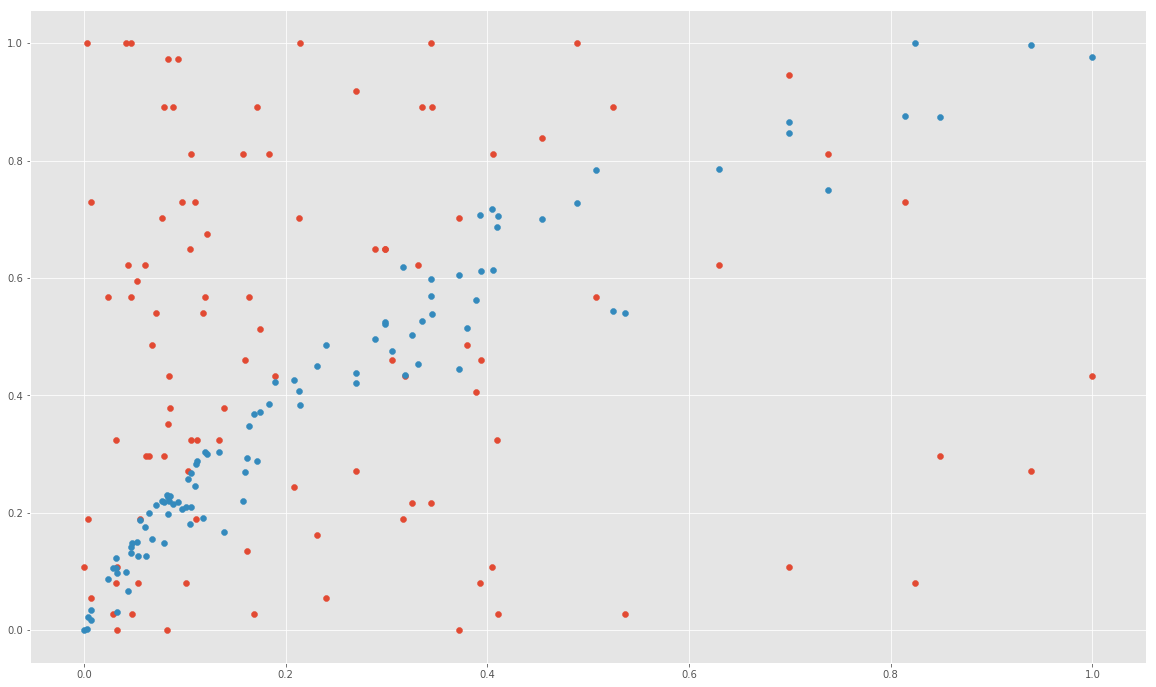

In [9]:
plt.scatter(normalized_df.time,normalized_df.CUTOFF_RADIUS)
plt.scatter(normalized_df.time,normalized_df.density)

In [10]:
X = normalized_df[params_4].values
Y = normalized_df['time'].values

In [11]:
builder = LearnerBuilder()
builder.buildRegressor()
builder.withTrainingDataFromNumPyArray(X, Y)
builder = builder.withGrid()
#builder.withPolynomialBase(3)
builder = builder.withLevel(5)
builder = builder.withSpecification()
builder.withLambda(1.e-9)
builder.withIdentityOperator()
builder = builder.withStopPolicy()
builder = builder.withCGSolver()
builder.withAccuracy(0.0001)
builder.withImax(600)

In [12]:
learner = builder.andGetResult()

In [13]:
print learner.specification.toString()
learner.specification.setAdaptPoints(100)

{'module' : 'pysgpp.extensions.datadriven.learner.TrainingSpecification',
'_TrainingSpecification__adaptPoints' : 0,
'_TrainingSpecification__adaptRate' : 0,
'_TrainingSpecification__adaptThreshold' : 0.0,
'_TrainingSpecification__cOperatorType' : 'identity',
'_TrainingSpecification__l' : 1e-09}


In [14]:
learner.learnData()

<pysgpp.pysgpp_swig.DataVector; proxy of <Swig Object of type 'sgpp::base::DataVector *' at 0x7f237e9783c0> >

In [15]:
print learner.toString()

{"module" : "pysgpp.extensions.datadriven.learner.Regressor",
"_Learner__SERIALIZABLE_ATTRIBUTES" : ["eventControllers", "dataContainer", "stopPolicy", "specification", "grid", "knowledge", "foldingPolicy", "solver"],
"dataContainer" : {"module" : "pysgpp.extensions.datadriven.data.DataContainer",
"train" : {"module" : "pysgpp.extensions.datadriven.data.DataSpecification",
"filename":"data.1518456932.81285.arff"
,"x0" : "NUMERIC","x1" : "NUMERIC","class" : "NUMERIC"}}
,
"eventControllers" : [],
"iteration" : 1,
"numberPoints" : [129],
"solver" : {"module" : "pysgpp.extensions.datadriven.learner.solver.CGSolver",
"DEFAULT_ACCURACY" : 0.0001,
"DEFAULT_IMAX" : 400,
"eventControllers" : [],
"max_threshold" : -1}
,
"specification" : {"module" : "pysgpp.extensions.datadriven.learner.TrainingSpecification",
"_TrainingSpecification__adaptPoints" : 100,
"_TrainingSpecification__adaptRate" : 0,
"_TrainingSpecification__adaptThreshold" : 0.0,
"_TrainingSpecification__cOperatorType" : "identity",


In [16]:
print learner.alpha.minmax()
print learner.trainAccuracy
print learner.getCurrentIterationNumber()
print learner.grid.getDegree()
print learner.getL2NormError()
print learner.getMaxError()
print learner.getMinError()


[-5.829664344400044, 24.49572239714485]
[0.012341515499750225]
1
1
1.11092373725
0.82451808555
0.0


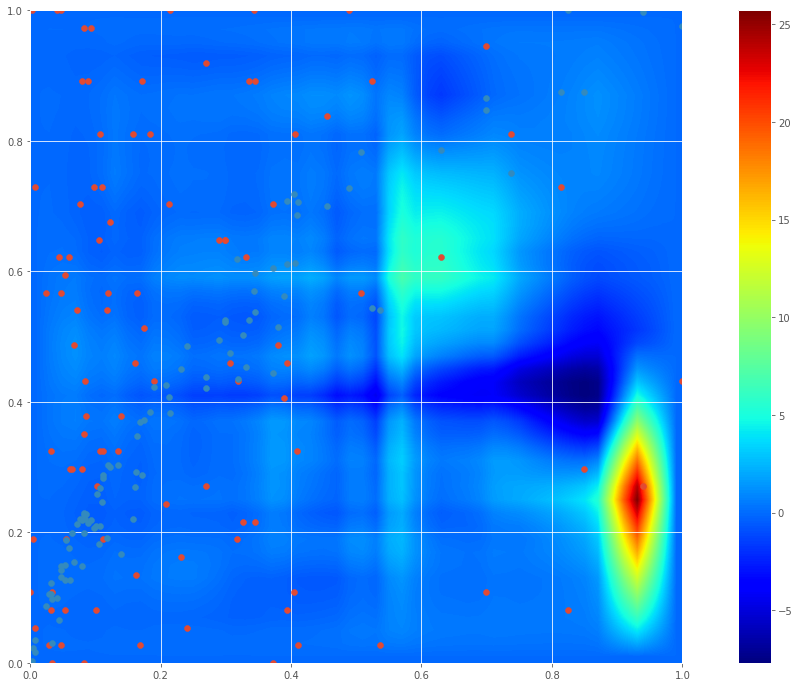

In [17]:
#plt.scatter(X, X)
plt.scatter(normalized_df.time,normalized_df.CUTOFF_RADIUS)
plt.scatter(normalized_df.time,normalized_df.density)
plotSG2d(learner.grid, learner.alpha)
plt.show()

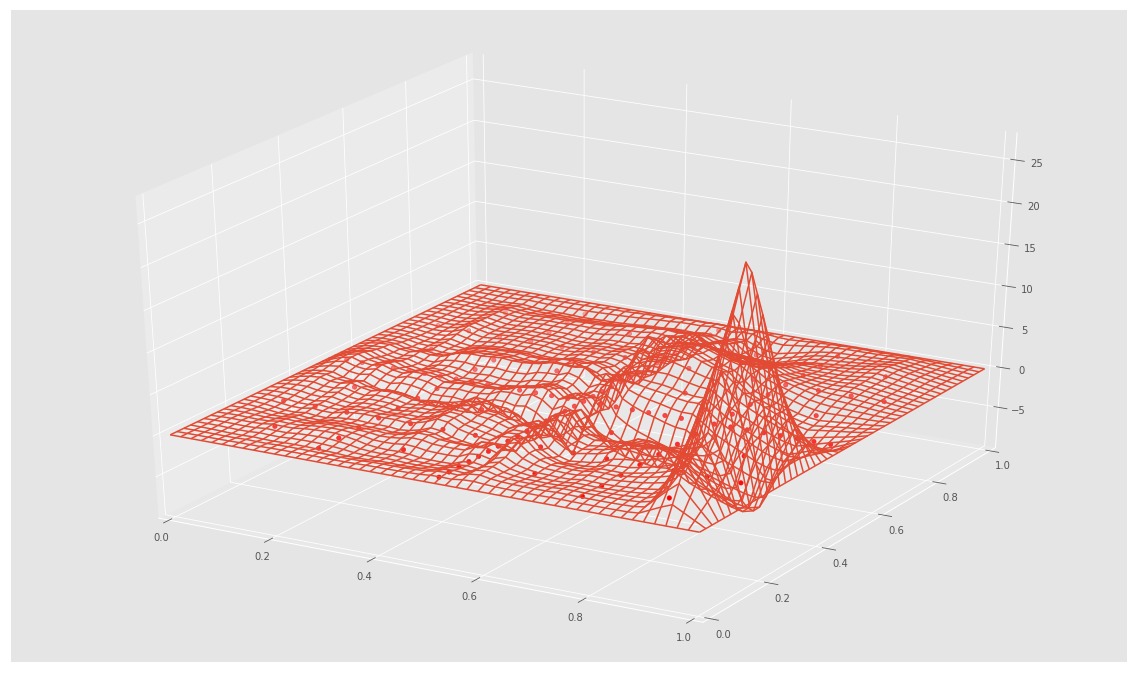

In [18]:
plotSG3d(learner.grid, learner.alpha)
plt.show()

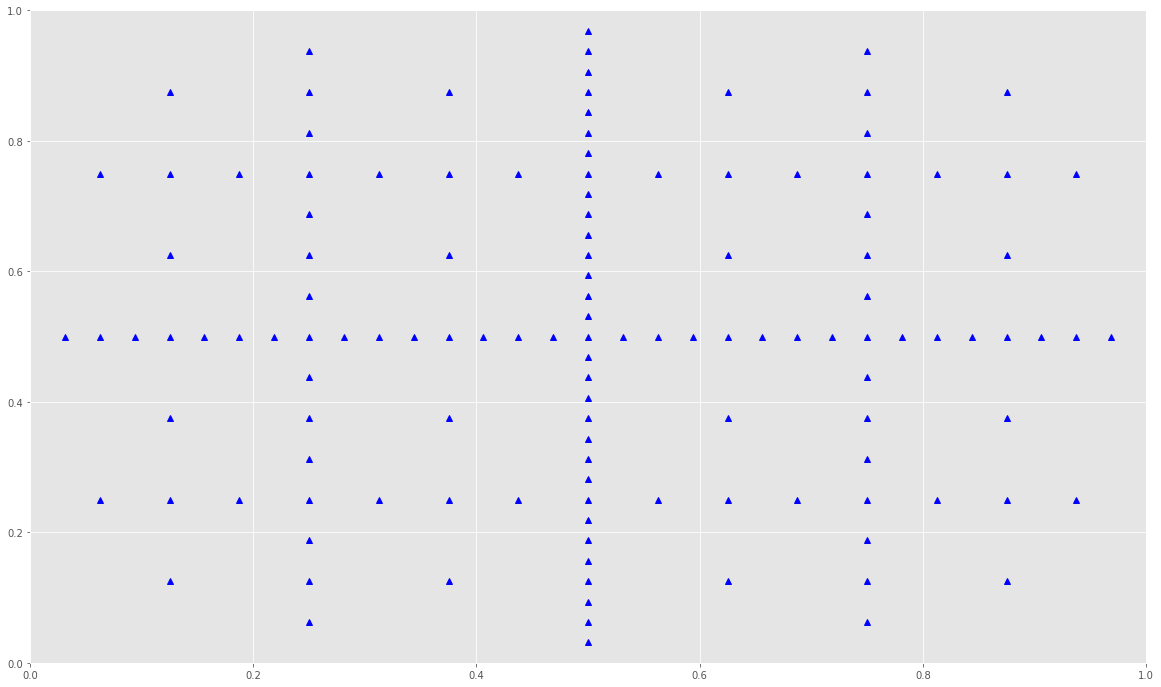

In [19]:
plotGrid2d(learner.grid)

In [20]:
################################################################################################

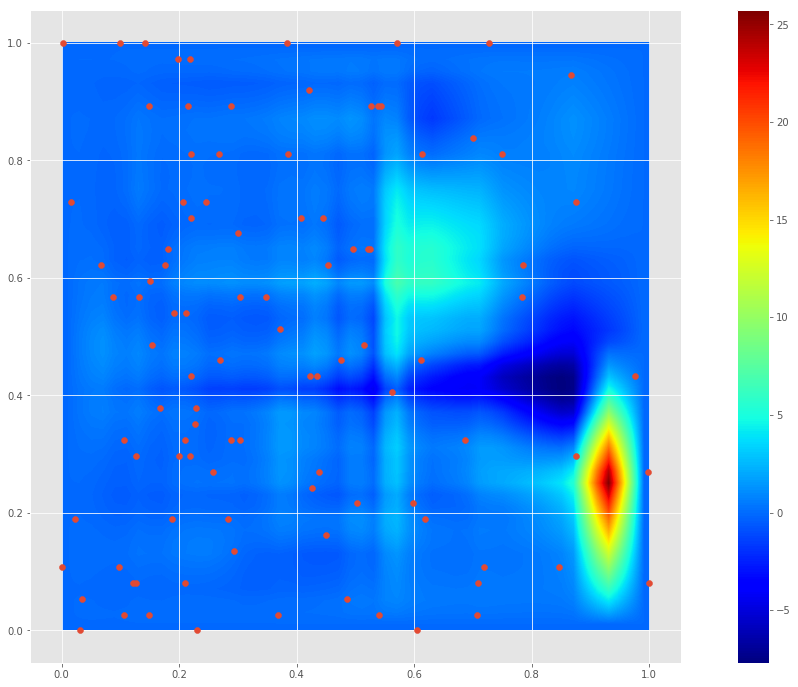

In [21]:
if X.shape[1] == 1:
    plt.scatter(X, X)
    plotSG1d(learner.grid, learner.alpha, color="red")
if X.shape[1] == 2:
    plotSG2d(learner.grid, learner.alpha)
    plt.scatter(X[:, 0], X[:, 1])
else:
    plotSG3d(learner.grid, learner.alpha)
    plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [22]:
numSamples = 100
numDims = 2
def f(x):
    return np.prod(4. * x * (1 - x), axis=1)
print "generate uniformly distributed samples (%i, %i)" % (numSamples, numDims)
samples = np.random.rand(numSamples, numDims)
values = f(samples)

generate uniformly distributed samples (100, 2)


In [23]:
samples.shape

(100, 2)

In [24]:
builder = LearnerBuilder()
builder.buildRegressor()
builder.withTrainingDataFromNumPyArray(samples,values)
builder = builder.withGrid()
builder.withLevel(5)
builder = builder.withSpecification()
builder.withLambda(1.e-9)

# builder.withLaplaceOperator()
builder.withIdentityOperator()
builder = builder.withStopPolicy()
builder = builder.withCGSolver()

builder.withImax(400)
learner = builder.andGetResult()

In [25]:
learner.learnData()
# # Do the learning
learner = builder.andGetResult()
learner.specification.setAdaptPoints(50)
learner.specification.toString
gs = learner.grid.getStorage()

In [26]:
#for i in range(10):
#    learner.learnData()
#    learner.refineGrid()

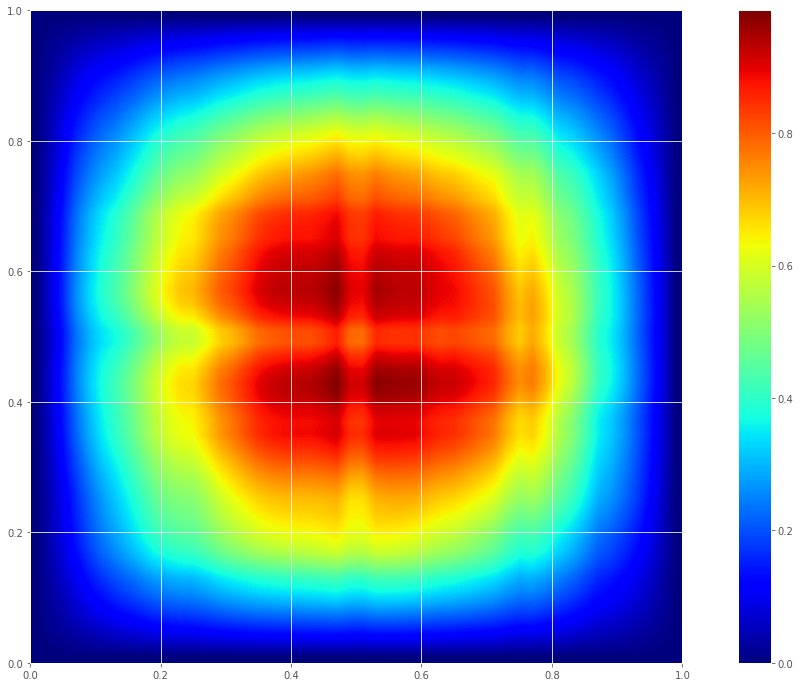

In [27]:
plotSG2d(learner.grid, learner.alpha)
#plt.scatter(samples[:, 0], samples[:, 1], c='blue', alpha=1, s=25)
plt.show()

In [28]:
print learner.alpha.minmax()
print learner.trainAccuracy
print learner.getCurrentIterationNumber()
print learner.grid.getDegree()
print learner.getL2NormError()
print learner.getMaxError()
print learner.getMinError()

[-0.03427468327508092, 0.714727999924412]
[5.930166233521062e-07]
1
1
0.00770075725726
0.00247034405374
4.03476038313e-06


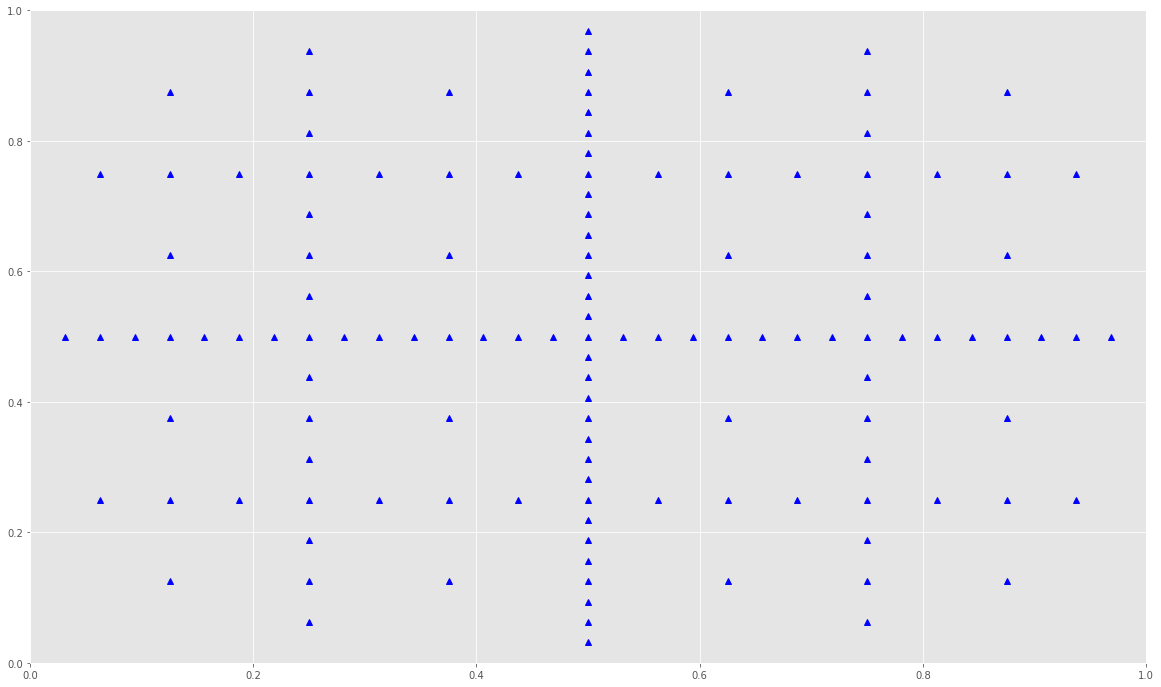

In [29]:
plotGrid2d(learner.grid)

In [30]:
class SimpleFunction(pysgpp.OptScalarFunction):
    def __init__(self):
        super(SimpleFunction, self).__init__(8)
    def eval(self, x):
        """Evaluates the function."""
        return x[0] * x[1] * x[2] * x[3] * x[4] * x[5] * x[6] * x[7]
def printLine():
    print "----------------------------------------"

In [31]:
# objective function
f = SimpleFunction()
# dimension of domain
d = f.getNumberOfParameters()
#d = 8
# B-spline degree
p = 3
# maximal number of grid points
N = 30
# adaptivity of grid generation
gamma = 0.95

In [32]:
print "sgpp::optimization example program started.\n"
# increase verbosity of the output
pysgpp.OptPrinter.getInstance().setVerbosity(2)

sgpp::optimization example program started.



In [33]:
grid = pysgpp.Grid.createModBsplineGrid(d, p)
gridGen = pysgpp.OptIterativeGridGeneratorRitterNovak(f, grid, N, gamma)

In [34]:
printLine()
print "Generating grid...\n"
if not gridGen.generate():
    print "Grid generation failed, exiting."
    sys.exit(1)

----------------------------------------
Generating grid...



In [35]:
printLine()
print "Hierarchizing...\n"
functionValues = gridGen.getFunctionValues()
coeffs = pysgpp.DataVector(len(functionValues))
hierSLE = pysgpp.OptHierarchisationSLE(grid)
sleSolver = pysgpp.OptAutoSLESolver()
# solve linear system
if not sleSolver.solve(hierSLE, gridGen.getFunctionValues(), coeffs):
    print "Solving failed, exiting."
    sys.exit(1)

----------------------------------------
Hierarchizing...



In [36]:
printLine()
print "Optimizing smooth interpolant...\n"
ft = pysgpp.OptInterpolantScalarFunction(grid, coeffs)
ftGradient = pysgpp.OptInterpolantScalarFunctionGradient(grid, coeffs)
gradientDescent = pysgpp.OptGradientDescent(ft, ftGradient)
x0 = pysgpp.DataVector(d)

----------------------------------------
Optimizing smooth interpolant...



In [37]:
gridStorage = gridGen.getGrid().getStorage()
# index of grid point with minimal function value
x0Index = 0
fX0 = functionValues[0]
for i in range(1, len(functionValues)):
    if functionValues[i] < fX0:
        fX0 = functionValues[i]
        x0Index = i
x0 = gridStorage.getCoordinates(gridStorage.getPoint(x0Index));
ftX0 = ft.eval(x0)
print "x0 = {}".format(x0)
print "f(x0) = {:.6g}, ft(x0) = {:.6g}\n".format(fX0, ftX0)

x0 = [1.25000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01, 5.00000000000000000000e-01]
f(x0) = 0.000976562, ft(x0) = 0.000976562



In [38]:
gradientDescent.setStartingPoint(x0)
gradientDescent.optimize()
xOpt = gradientDescent.getOptimalPoint()
ftXOpt = gradientDescent.getOptimalValue()
fXOpt = f.eval(xOpt)
print "\nxOpt = {}".format(xOpt)
print "f(xOpt) = {:.6g}, ft(xOpt) = {:.6g}\n".format(fXOpt, ftXOpt)


xOpt = [2.71653468489519229845e-10, 4.82790754573174107911e-01, 4.82790754573174107911e-01, 4.82790754573174107911e-01, 4.82790754573174107911e-01, 4.82790754573174107911e-01, 4.82790754573174107911e-01, 4.82790754573174107911e-01]
f(xOpt) = 1.66084e-12, ft(xOpt) = 9.71769e-05



In [39]:
printLine()
print "Optimizing objective function (for comparison)...\n"
nelderMead = pysgpp.OptNelderMead(f, 1000)
nelderMead.optimize()
xOptNM = nelderMead.getOptimalPoint()
fXOptNM = nelderMead.getOptimalValue()
ftXOptNM = ft.eval(xOptNM)
print "\nxOptNM = {}".format(xOptNM)
print "f(xOptNM) = {:.6g}, ft(xOptNM) = {:.6g}\n".format(fXOptNM, ftXOptNM)
printLine()
print "\nsgpp::optimization example program terminated."

----------------------------------------
Optimizing objective function (for comparison)...


xOptNM = [9.83974716857793030300e-01, 9.36964139473490331689e-01, 1.62080263718904166115e-21, 5.90040099519758665103e-01, 6.58030120438298449237e-01, 3.69130672216065325308e-01, 1.86779332504047629326e-01, 4.40216768275729503079e-02]
f(xOptNM) = 1.76092e-24, ft(xOptNM) = -0.00553962

----------------------------------------

sgpp::optimization example program terminated.
